<a href="https://colab.research.google.com/github/ajmal92/datascience/blob/main/Netflix_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# # Data Cleanup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [ ]:
df = pd.read_csv('/Users/ajmal.m/Downloads/netflix.txt')

#### Steps involved in cleaning
- swapping rating and duration where rating has duration values and duration is NA
- year(date_added) cannot be greater than release_year. Change release yaer to year(date_added)
- split director, cast, country, listed_in to separate rows ( long format )
- Improve fill rate of country 
    - fill with most popular country of the associated director
    - If the director is NAN, consider the most popular cast in the movie and fill it with most frequent country of the most popular cast in the movie
     - if cast and director is Not available, fill with popular most country in the dataset
- Improve fill rate of rating
    - Fill with the average rating for the show_type (movie /tv-show)

In [ ]:
# swapping rows where rating has duration & duration is NA
ind_rating_with_duration = df[(df['duration'].isna()) & (df['rating'].str.endswith('min'))].index.values
df.loc[ind_rating_with_duration,['rating','duration']] = df.loc[ind_rating_with_duration,['duration', 'rating']].values

# change date_added to date time
df['date_added'] = pd.to_datetime(df['date_added'])

# year(date_added) cannot be greater than release_year. preserve date and month, change year component
ind_release_yr_lt_dt_added = df.loc[df['date_added'].dt.year < df['release_year']].index.values
df.loc[ind_release_yr_lt_dt_added,['release_year']] = df.loc[ind_release_yr_lt_dt_added]['date_added'].dt.year.values

# change to long format 
df[['cast', 'director', 'country','listed_in']]  = df[['cast', 'director', 'country','listed_in']].apply(lambda x: x.str.split(","))
df = df.explode('cast').reset_index(drop=True)
df = df.explode('director').reset_index(drop=True)
df = df.explode('country').reset_index(drop=True)
df = df.explode('listed_in').reset_index(drop=True)

df[['cast', 'director', 'country','listed_in']] = df[['cast', 'director', 'country','listed_in']].apply(lambda x: x.str.strip())

def fill_na(x):
    d_mode = x.mode()
    d_mode = d_mode.iloc[0] if len(d_mode)>0 else np.nan
    dt = x.fillna(d_mode)
    return dt


df_temp = df.loc[(~df['director'].isna())]
idx = df_temp.index
df_temp['country'] = df_temp.groupby(by=['director'],group_keys=False)['country'].apply(fill_na)
df.loc[idx,['country']]= df_temp.loc[idx,['country']].values

# finding most popular cast in a movie
df['cast_movies'] = df.groupby(by='cast')['show_id'].transform('nunique')
# sort dataframe by partitioning column 'title' and sorting column 'cast_movies' in descending order
df = df.sort_values(by=['title', 'cast_movies'], ascending=[True, False])
# create new column 'first_cast' with the first value of 'cast' within each group based on the descending order of 'cast_movies'
df['popular_cast'] = df.groupby('title')['cast'].transform(lambda x: x.iloc[0])
df.drop('cast_movies', axis=1, inplace=True)


df_temp = df.loc[(~df['popular_cast'].isna()) & (df['country'].isna())]
idx = df_temp.index
def calculate_mode(x):
    if len(x.mode())>0:
        return x.mode().iloc[0]
    else:
        return np.NaN
df_temp['popular_cast_country'] = df_temp.groupby(by=['popular_cast'])['country'].transform(calculate_mode)
df_temp['country'] = df_temp['country'].fillna(df_temp['popular_cast_country'])
df.loc[idx,['country']]= df_temp.loc[idx,['country']].values
df['country'] = df['country'].fillna(df['country'].mode().iloc[0])


# filling rating 
df['rating'] = df.groupby(by=['type', 'country'])['rating'].apply(lambda x: x.fillna(x.mode().iloc[0]))
df['rating'] = df.groupby(by=['type'])['rating'].apply(lambda x: x.fillna(x.mode().iloc[0]))

def calculate_mode(x):
    if len(x.mode())>0:
        return x.mode().iloc[0]
    else:
        return np.NaN
df['popular_cast_country'] = df.groupby(by=['popular_cast'])['country'].transform(calculate_mode)

df['director'] = df['director'].fillna('Unavailable')


In [ ]:
df.drop_duplicates(['show_id']).shape

(8807, 14)

In [ ]:
df['release_year'].min(), df['release_year'].max()

(1925, 2021)

In [ ]:
df['director'].nunique(), df['cast'].nunique(), df['country'].nunique(), df['listed_in'].nunique()

(4993, 36439, 123, 42)

- Release Year is in the range 1925 to 2021
- There are 4993 different directors and 36439 different cast
- Netflix has shows produced in 123 countries
- Netflix has content in 42 different categories
- Data contains 8807 records

# # Insights and Recommendations

/var/folders/99/lknm6hjj5hdflvp0wxl6djgh0000gn/T/ipykernel_10117/895894847.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country_type['country'] = df_country_type['country'].replace('United Kingdom', 'UK')


Text(0.5, 0, '')

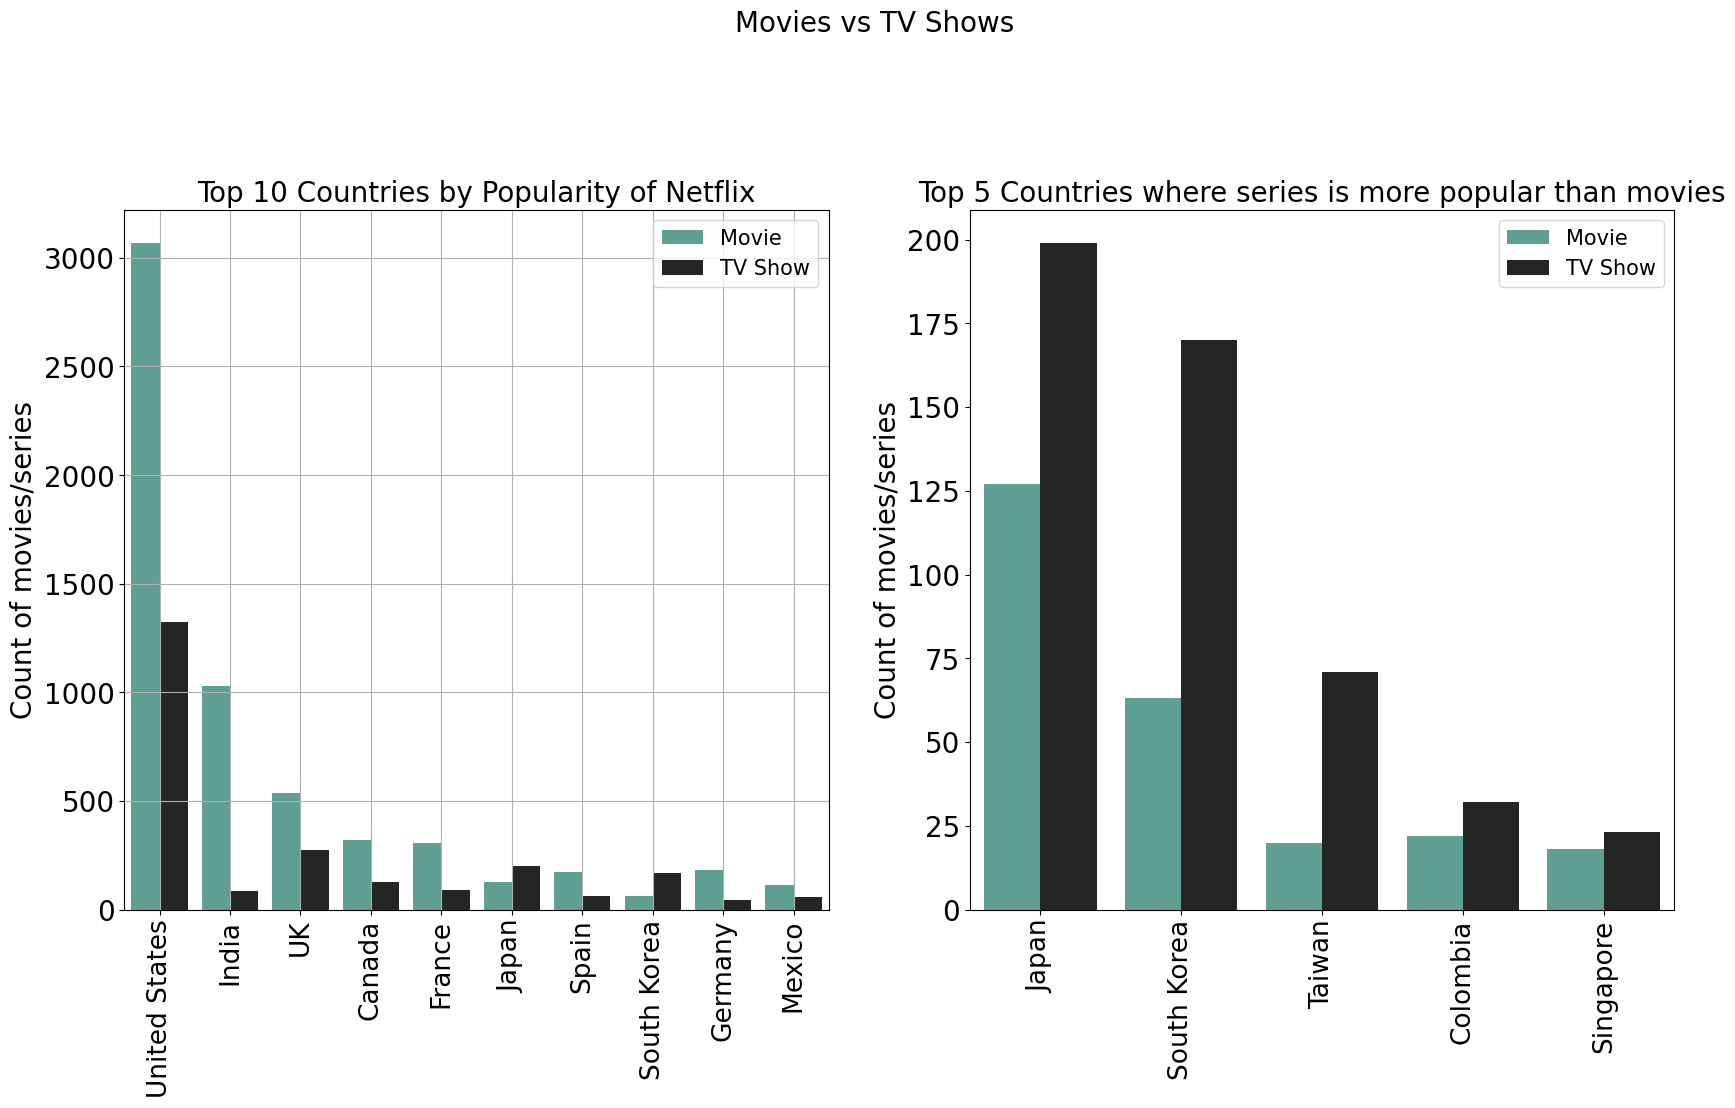

In [ ]:
plt.figure(figsize=(20,20)).suptitle("Movies vs TV Shows",fontsize=20)
plt.subplot(2, 2, 1)

x_ticks_font = 19
y_ticks_font = 20
legend_font_size = 15

df_country_type = df.drop_duplicates(['show_id', 'type', 'country'])
df_country_type['country'] = df_country_type['country'].replace('United Kingdom', 'UK')

order = df_country_type['country'].value_counts().nlargest(10).index
sns.countplot(df_country_type.loc[df_country_type['country'].isin(order)], x='country', hue='type', order=order, palette= 'dark:#5A9_r')
plt.ylabel('Count of movies/series', fontsize=20)
plt.title('Top 10 Countries by Popularity of Netflix', fontsize=20)
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=x_ticks_font)
plt.tick_params(axis='y', labelsize=y_ticks_font)
plt.xlabel('')
# plt.subplots(figsize=(6, 8))
plt.legend(fontsize=legend_font_size)
plt.grid(True)


plt.subplot(2, 2, 2)
df_t = df_country_type.groupby(by=['country', 'type'])['show_id'].count().reset_index()
df_t = df_t.pivot_table(index='country', columns='type').reset_index()
df_t.columns = ['country', 'movie_count', 'tv_show_count']
df_t['movie_count'].fillna(0, inplace=True)
df_t['tv_show_count'].fillna(0, inplace=True)
ls = df_t.loc[df_t['tv_show_count']> df_t['movie_count']].sort_values(by=['tv_show_count'], ascending=False).iloc[:5]['country'].values

order2 = ls
df_series = df_country_type.loc[df_country_type['country'].isin(ls)]
sns.countplot(df_series, x='country', hue='type', order=order2, palette= 'dark:#5A9_r')
plt.ylabel('Count of movies/series', fontsize=20)
plt.title('Top 5 Countries where series is more popular than movies', fontsize=20)
plt.tick_params(axis='x', labelsize=x_ticks_font)
plt.tick_params(axis='y', labelsize=y_ticks_font)
plt.xticks(rotation=90)
plt.legend(fontsize=legend_font_size)
plt.xlabel('')


#### Insights

- Neflix is most popular in United States in terms of the total number of movies and series released
- In countries like Japan , South Korea and Taiwan series is more popular than movies

##### Recommendations
- Netflix should work towards producing more content in the form of TV-Shows in the countries like Japan/South Korea/Taiwan.


Text(0.5, 1.0, 'Top 5 countries vs Genre')

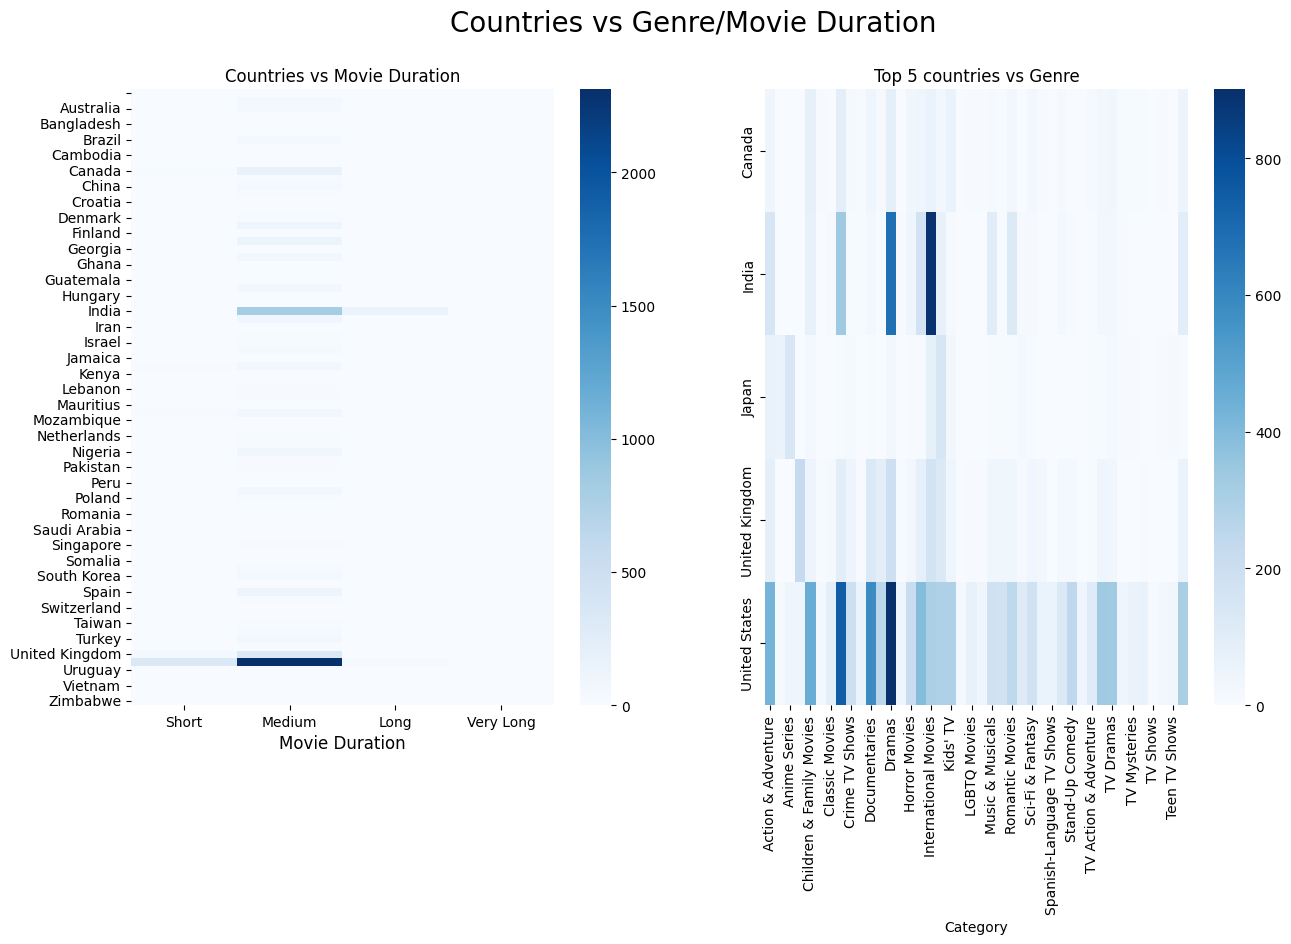

In [ ]:
plt.figure(figsize=(15,8)).suptitle("Countries vs Genre/Movie Duration",fontsize=20)
plt.subplot(1, 2, 1)

x_ticks_font = 19
y_ticks_font = 20
legend_font_size = 15

movie_data = df.drop_duplicates(['show_id'])
movie_data = movie_data.loc[movie_data['type']=='Movie']
movie_data['duration'] = movie_data['duration'].apply(lambda x: x.split(" ")[0])
movie_data['duration'] = pd.to_numeric(movie_data['duration'])
# create bins and labels for movie duration
bin_edges = [0, 60, 150,200, float('inf')]
bin_labels = ['Short', 'Medium', 'Long', 'Very Long']

# add column to dataframe with duration labels
movie_data['duration_label'] = pd.cut(movie_data['duration'], bins=bin_edges, labels=bin_labels)

# display dataframe with duration labels
movie_counts = pd.crosstab(movie_data.country, movie_data.duration_label)
ax=sns.heatmap(movie_counts, cmap='Blues')
plt.xlabel('Movie Duration', fontsize=12)
plt.ylabel('')
plt.title('Countries vs Movie Duration')

plt.subplot(1, 2, 2)
df_t = df.drop_duplicates(['show_id', 'country','listed_in'])
df_t = df_t.loc[df_t['country'].isin(['United States','India', 'United Kingdom', 'Japan', 'Canada'])]
# df_t = df_t.loc[df_t['listed_in'].isin(['Internation Movies', 'Dramas', 'Comedies','British TV Shows'])]
movie_counts = pd.crosstab(df_t.country, df_t.listed_in)
sns.heatmap(movie_counts, cmap='Blues')
plt.ylabel('')
plt.xlabel('Category')
plt.title("Top 5 countries vs Genre")


#### Insights

 - Viewers in United Kingdom have a strong affinity towards medium and short content
 - Viewers in India are aligned to towards medium and long content
 - Viewers in India and United States like content in Drama
 - Viewers in United States also like Documentaries, Classic Movies, Action & Adventure
 
#### Recommendations

- Viewers in India should continue to receive medium and long duration content.
- Viewers in United Kingdom should receive more of short duration content.


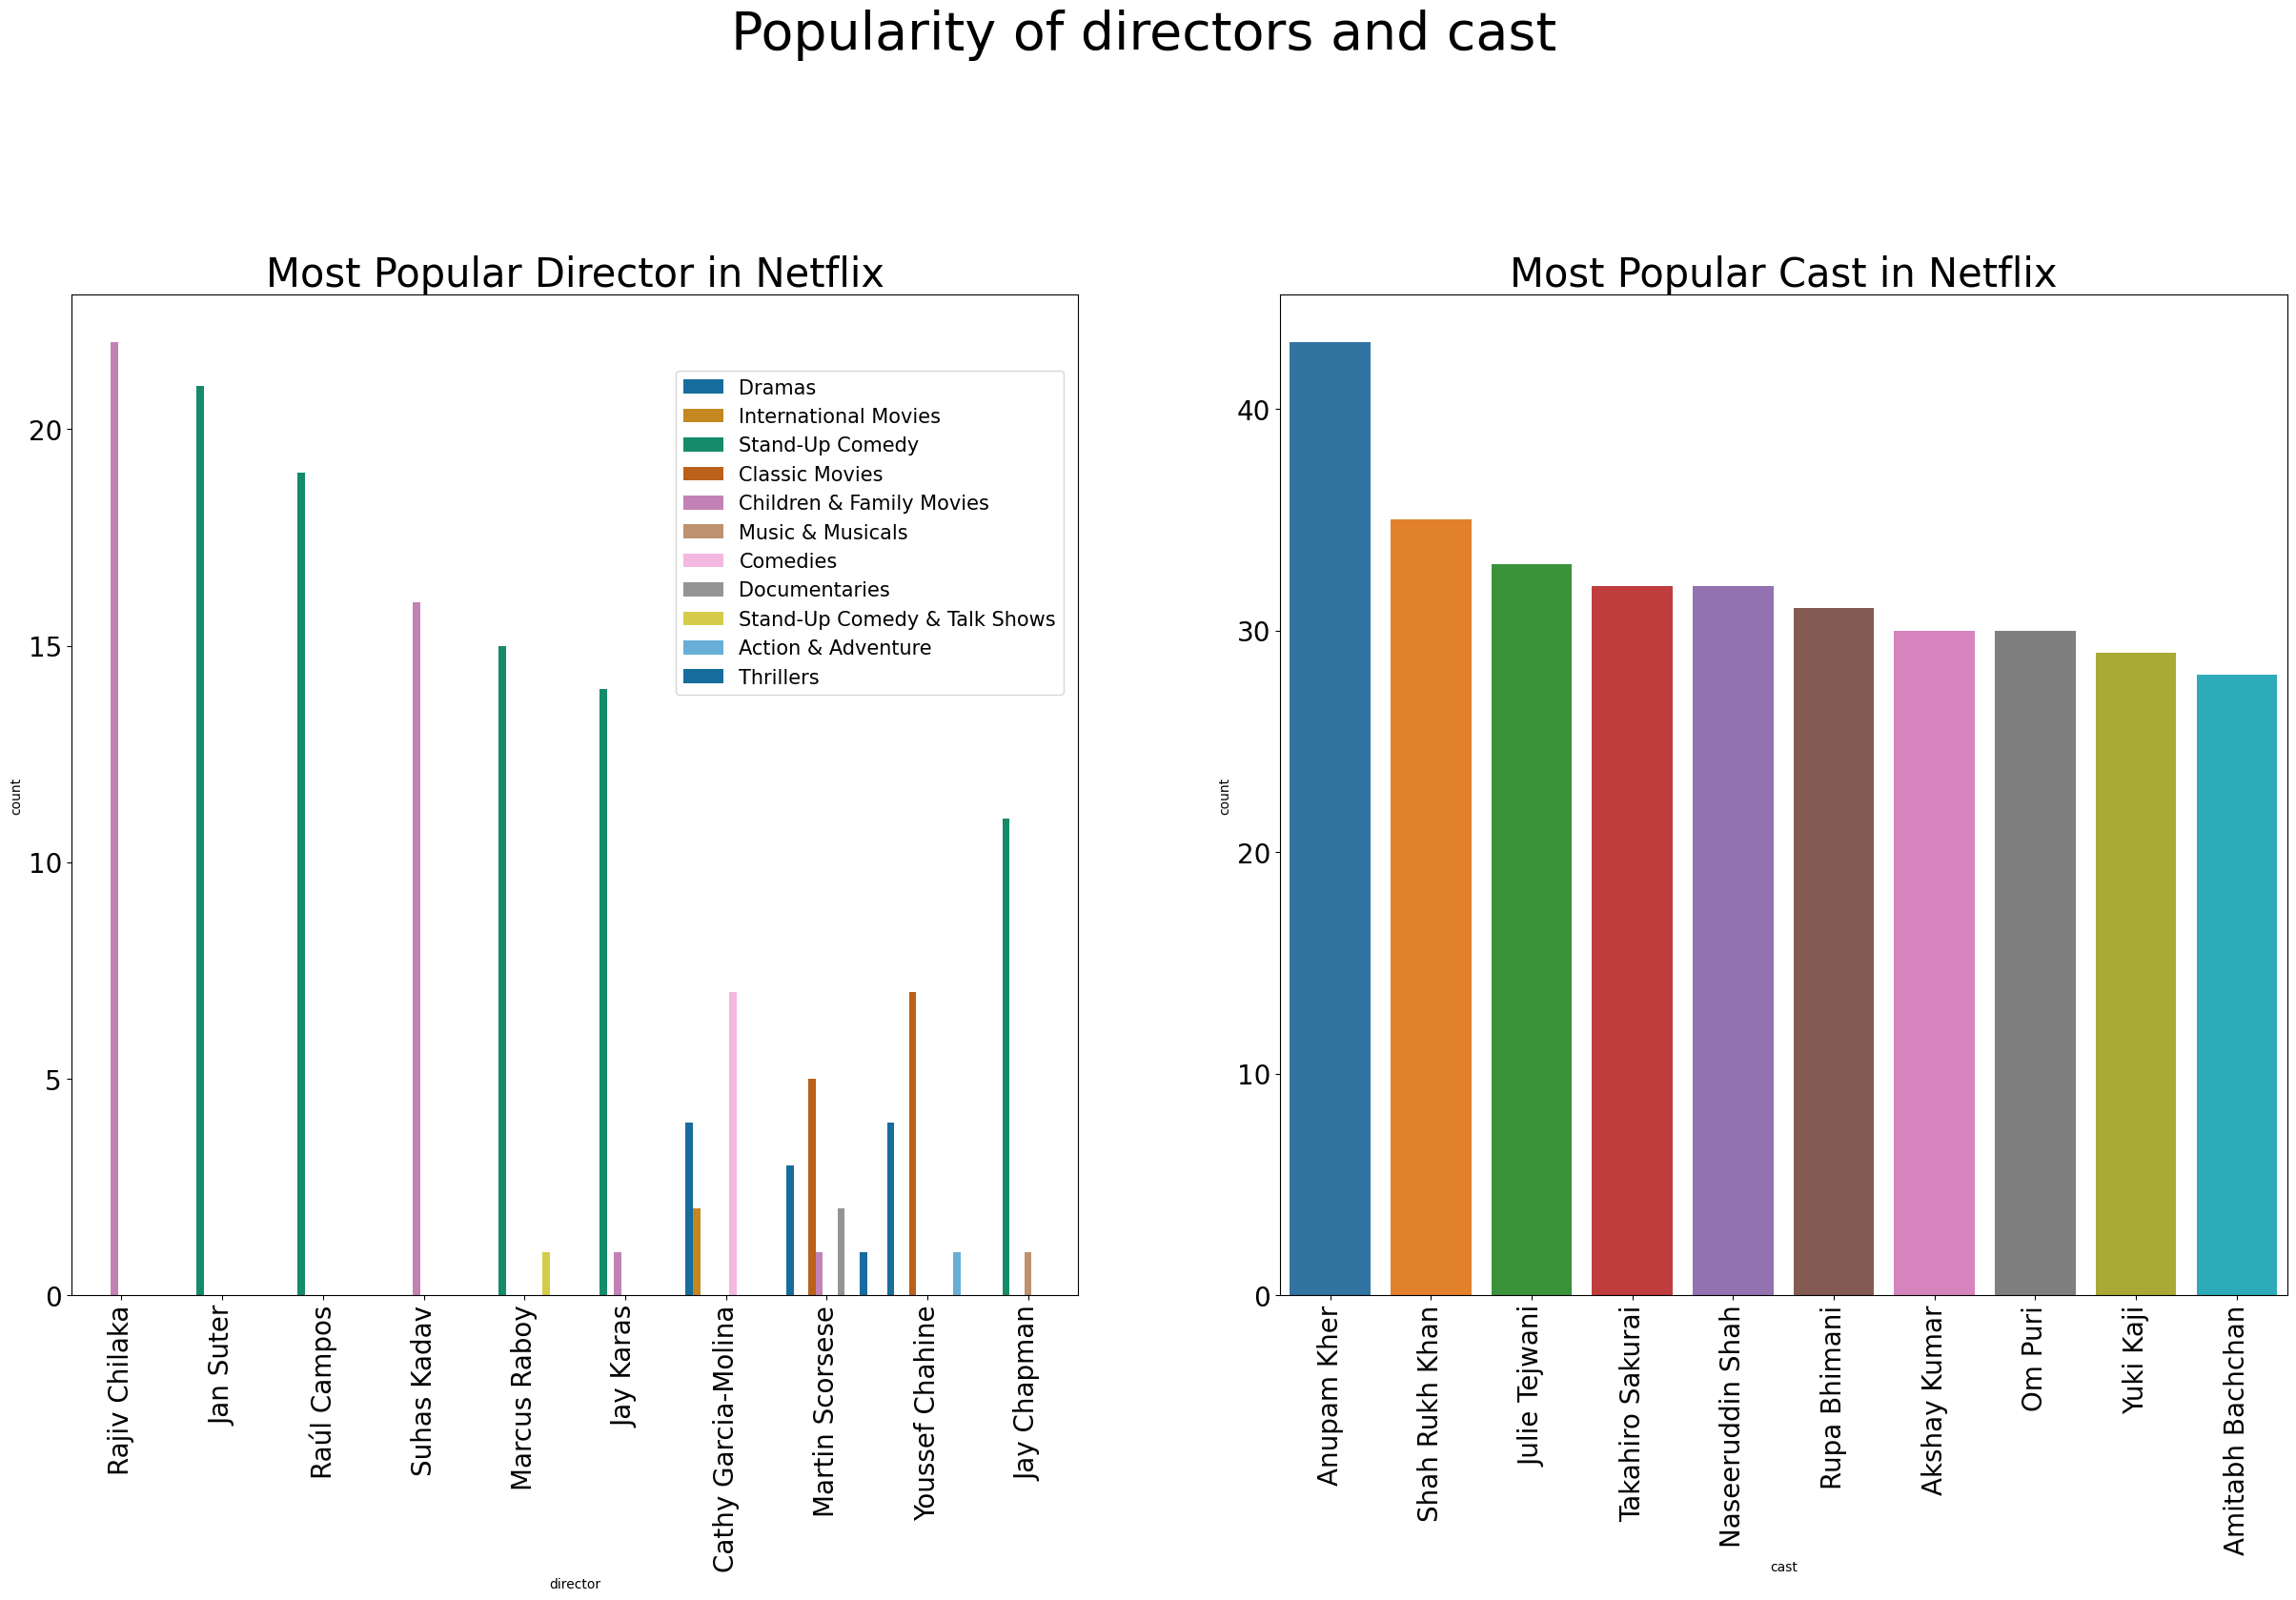

In [ ]:
plt.figure(figsize=(30,30)).suptitle("Popularity of directors and cast",fontsize=40)
plt.subplot(2, 2, 1)

x_ticks_font = 20
y_ticks_font = 20
legend_font_size = 15

df_t = df.drop_duplicates(['director', 'show_id'])
order = df_t['director'].value_counts().iloc[:10]
sns.countplot(df_t.loc[df_t['director'].isin(order.index.values)], x='director', hue='listed_in', palette='colorblind', order=order.index.values)
plt.xticks(rotation=90)
plt.title("Most Popular Director in Netflix", fontsize=30)
plt.tick_params(axis='y', labelsize=y_ticks_font)
plt.tick_params(axis='x', labelsize=x_ticks_font)
plt.legend(loc=(0.60, 0.60), fontsize=15)


## Most Popular Categories in Netflix
plt.subplot(2, 2, 2)
df_t = df.drop_duplicates(['cast', 'show_id'])
order = df_t['cast'].value_counts().iloc[:10]
sns.color_palette("Blues", as_cmap=True)
sns.countplot(df_t.loc[df_t['cast'].isin(order.index.values)], x='cast', order=order.index.values)
plt.xticks(rotation=90)
sns.color_palette("Blues", as_cmap=True)
plt.title("Most Popular Cast in Netflix", fontsize=30)
plt.tick_params(axis='y', labelsize=y_ticks_font)
plt.tick_params(axis='x', labelsize=x_ticks_font)


- Rajiv Chilaka is the director with maximum number of movies/shows in the dataset. All of his movies are in Children& Family movies category
- Anupam Kher is the actor that is present in most number of shows in the dataset followed by Shah Rukh Khan

##### Recommendations
- Owing to the popularity of Anupam Kher and Shah Rukh Khan in the data, Netflix should plan to bring more of Indian movies starring both of these lead actors.

- Rajiv Chilaka has primarily directed Children&Family movies. Bringing in more movies/shows belonging to this category can attrack more viewes

/var/folders/99/lknm6hjj5hdflvp0wxl6djgh0000gn/T/ipykernel_10117/79612998.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['year_added'] = df_t['date_added'].dt.year


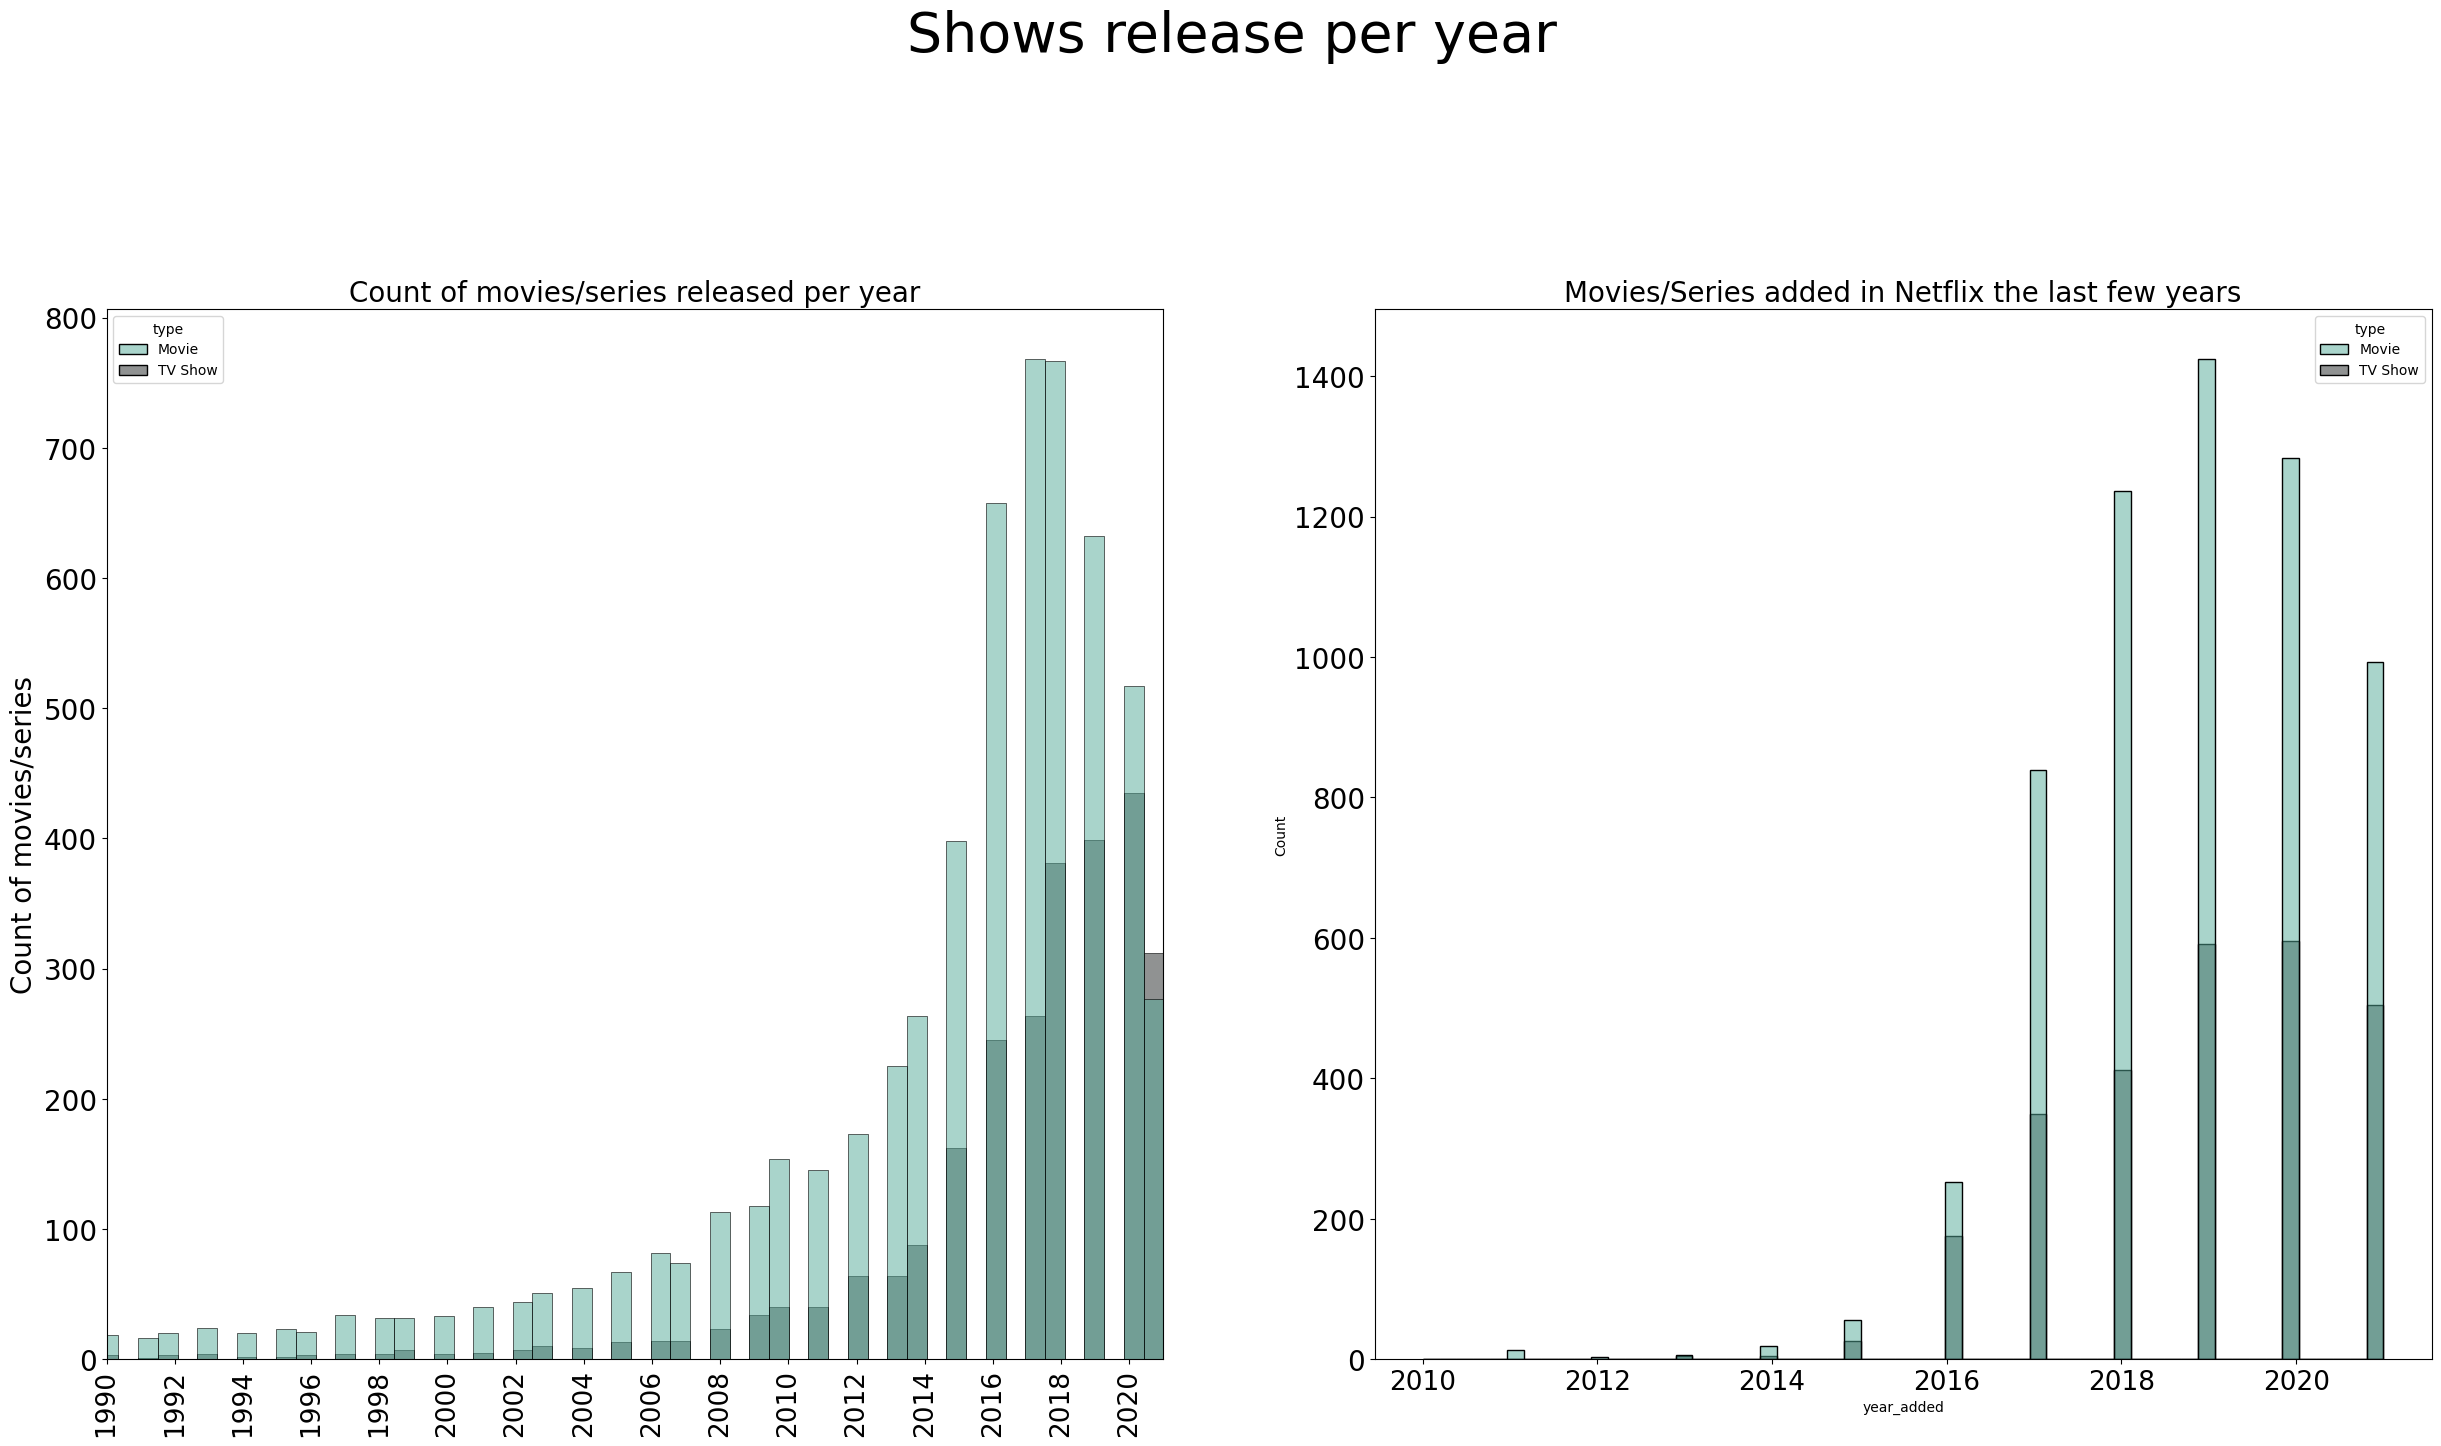

In [ ]:
plt.figure(figsize=(30,30)).suptitle("Shows release per year",fontsize=40)
plt.subplot(2, 2, 1)

x_ticks_font = 19
y_ticks_font = 20
legend_font_size = 15


df_movies_shows = df.drop_duplicates(['release_year','show_id','type'])
sns.histplot(data=df_movies_shows, x='release_year', hue='type', palette= 'dark:#5A9_r')
plt.xticks(np.arange(1990, 2021, 2),rotation=90)
plt.xlim(1990,2021)
plt.ylabel('Count of movies/series', fontsize=20)
plt.xlabel('')
plt.title('Count of movies/series released per year', fontsize=20)
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tick_params(axis='x', labelsize=x_ticks_font)
plt.tick_params(axis='y', labelsize=y_ticks_font)
# plt.legend(fontsize=10)
# plt.legend(fontsize=legend_font_size)


plt.subplot(2, 2, 2)

df_t = df.drop_duplicates(['show_id'])
df_t['year_added'] = df_t['date_added'].dt.year
df_his = df_t.loc[df_t['year_added'].between(2010,2022)]
sns.histplot(df_his, x='year_added', hue='type', palette= 'dark:#5A9_r')
plt.title('Movies/Series added in Netflix the last few years', fontsize=20)
plt.tick_params(axis='y', labelsize=y_ticks_font)
plt.tick_params(axis='x', labelsize=x_ticks_font)





##### Insights
- The number of movies/tv-series released/year has increased in the last 20-30 years.
- The number of movies released has peaked in 2017-2018.
- The number of series released/year has peaked in 2020.


Text(0, 0.5, 'Count of movies')

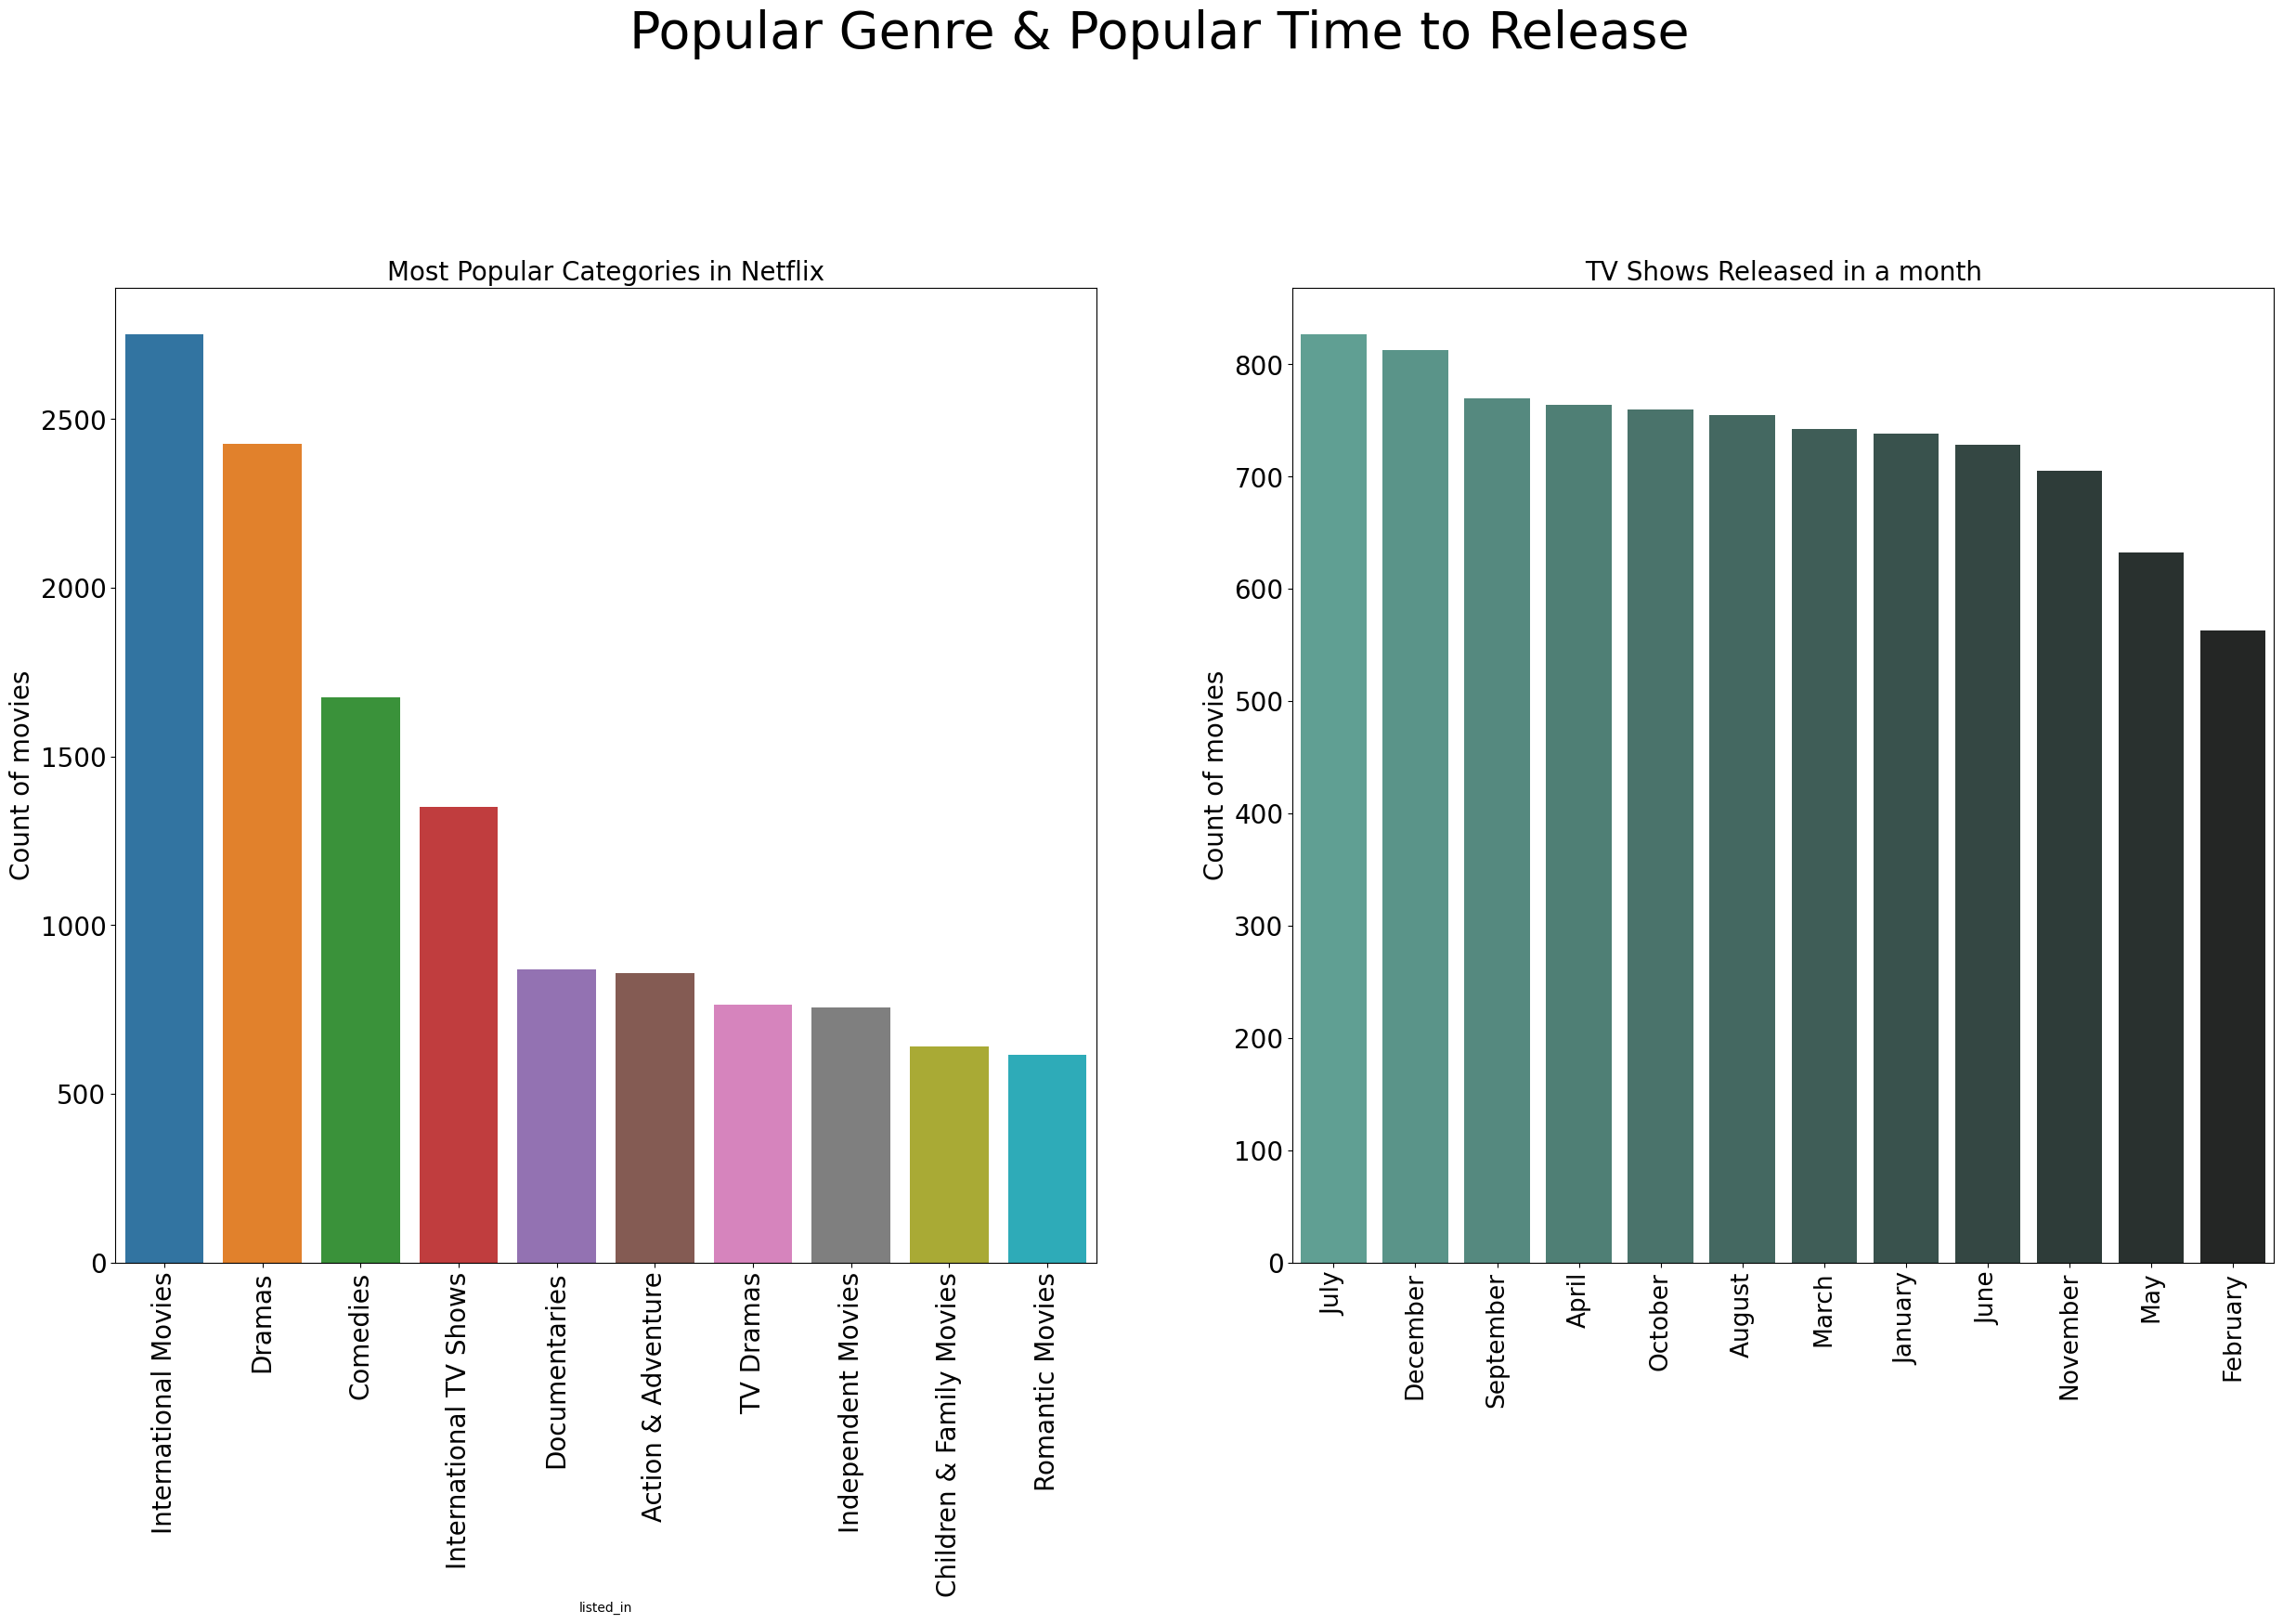

In [ ]:
plt.figure(figsize=(30,30)).suptitle("Popular Genre & Popular Time to Release",fontsize=40)
plt.subplot(2, 2, 1)

x_ticks_font = 19
y_ticks_font = 20
legend_font_size = 15

## Most Popular Categories in Netflix
df_t = df.drop_duplicates(['listed_in', 'show_id'])
order = df_t['listed_in'].value_counts().iloc[:10]
sns.countplot(df_t.loc[df_t['listed_in'].isin(order.index.values)], x='listed_in', order=order.index.values)
plt.xticks(rotation=90)
plt.title("Most Popular Categories in Netflix", fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylabel('Count of movies', fontsize=20)

plt.subplot(2, 2, 2)

order=df_deduped['month_added'].value_counts().index
sns.countplot(df_deduped, x='month_added', order=order, palette='dark:#5A9_r')
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=x_ticks_font)
plt.tick_params(axis='y', labelsize=y_ticks_font)
plt.xlabel('')
plt.title("TV Shows Released in a month", fontsize=20)

plt.ylabel('Count of movies', fontsize=20)


- Majority of the movies released are listed in International Movies with the least being in Romantic
- Most of the TV Series are released in the month of July, December and September.

### Recommendations

- Netflix can plan to release more movies in the month of January and December as there are usually lot of holidays planned during this period.